# **Classifying images from Fashion MNIST using feedforward neural networks**

Dataset source: https://github.com/zalandoresearch/fashion-mnist


In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

## **Preparing the Data**

In [33]:
dataset = FashionMNIST(root= 'data/', download = True, transform=ToTensor())
test_dataset = FashionMNIST(root= 'data/', train=False, transform=ToTensor())

In [34]:
val_size = 12000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds)  , len(val_ds)

(48000, 12000)

In [35]:
batch_size = 116

In [36]:
train_loader = DataLoader(train_ds, batch_size, shuffle= True, num_workers = 2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*3, num_workers = 2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*3, num_workers = 2, pin_memory=True)


image.shape:  torch.Size([116, 1, 28, 28])


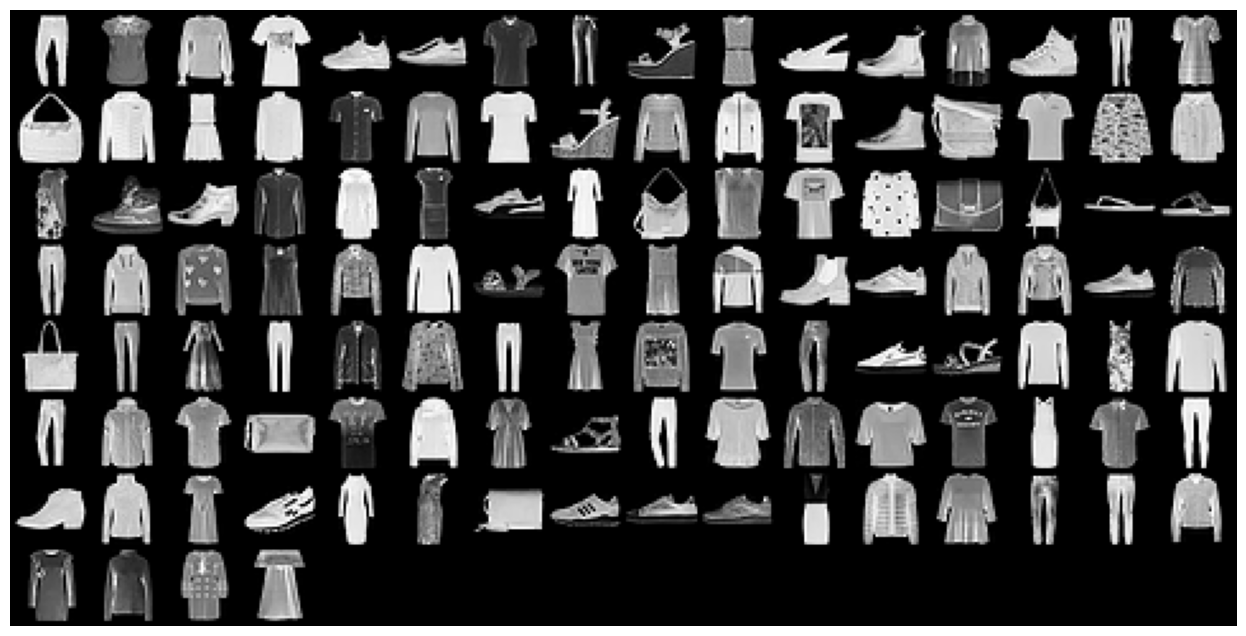

In [37]:
for images, _ in train_loader:
  print('image.shape: ', images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
  break

## **Model**

In [38]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))



In [39]:
class MnistModel(nn.Module):
  def __init__(self, in_size, out_size):
    super().__init__()
    self.linear1 = nn.Linear(in_size, 16)
    self.linear2 = nn.Linear(16, 32)
    self.linear3 = nn.Linear(32, 64)
    self.linear4 = nn.Linear(64, out_size)

  def forward(self, xb):
    out = xb.view(xb.size(0), -1)
    out = self.linear1(out)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)
    out = F.relu(out)
    out = self.linear4(out)
    return out

  def training_step(self, batch):
    images, labels = batch
    out = self(images)                  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)                    # Generate predictions
    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss, 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
      print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


## **Using a GPU**

In [40]:
torch.cuda.is_available()

True

In [41]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [42]:
device = get_default_device()
device

device(type='cuda')

In [43]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]

  return data.to(device, non_blocking=True)

In [44]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [45]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## **Training the model**

In [46]:
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):

    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history


In [47]:
input_size = 784

num_classes = 10

In [48]:
model = MnistModel(input_size, num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=10, bias=True)
)

In [49]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3023126125335693, 'val_acc': 0.11118929833173752}]

In [50]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.6916, val_acc: 0.7255
Epoch [1], val_loss: 0.5355, val_acc: 0.8086
Epoch [2], val_loss: 0.5965, val_acc: 0.7762
Epoch [3], val_loss: 0.4600, val_acc: 0.8334
Epoch [4], val_loss: 0.6928, val_acc: 0.7448


In [51]:
history += fit(8, 0.3, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4515, val_acc: 0.8381
Epoch [1], val_loss: 0.4506, val_acc: 0.8404
Epoch [2], val_loss: 0.4305, val_acc: 0.8477
Epoch [3], val_loss: 0.4730, val_acc: 0.8309
Epoch [4], val_loss: 0.4594, val_acc: 0.8365
Epoch [5], val_loss: 0.4227, val_acc: 0.8524
Epoch [6], val_loss: 0.4065, val_acc: 0.8542
Epoch [7], val_loss: 0.4171, val_acc: 0.8515


In [52]:
history += fit(8, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3942, val_acc: 0.8618
Epoch [1], val_loss: 0.3958, val_acc: 0.8602
Epoch [2], val_loss: 0.4022, val_acc: 0.8578
Epoch [3], val_loss: 0.3914, val_acc: 0.8615
Epoch [4], val_loss: 0.3979, val_acc: 0.8582
Epoch [5], val_loss: 0.3967, val_acc: 0.8603
Epoch [6], val_loss: 0.3989, val_acc: 0.8589
Epoch [7], val_loss: 0.3913, val_acc: 0.8626


In [53]:
history += fit(8, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3874, val_acc: 0.8634
Epoch [1], val_loss: 0.3880, val_acc: 0.8626
Epoch [2], val_loss: 0.3887, val_acc: 0.8635
Epoch [3], val_loss: 0.3893, val_acc: 0.8627
Epoch [4], val_loss: 0.3882, val_acc: 0.8633
Epoch [5], val_loss: 0.3882, val_acc: 0.8636
Epoch [6], val_loss: 0.3885, val_acc: 0.8642
Epoch [7], val_loss: 0.3883, val_acc: 0.8641


Text(0.5, 1.0, 'Loss vs. No. of epochs')

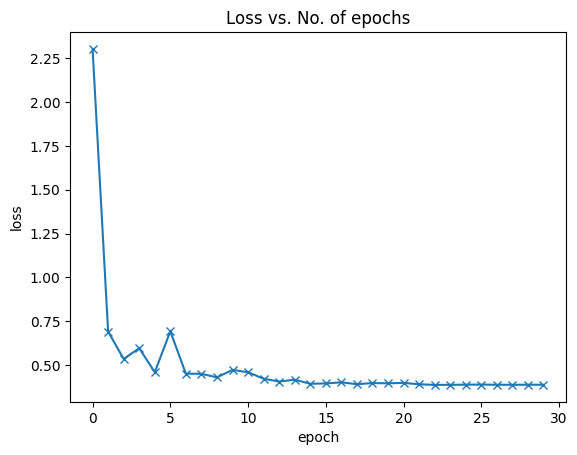

In [56]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

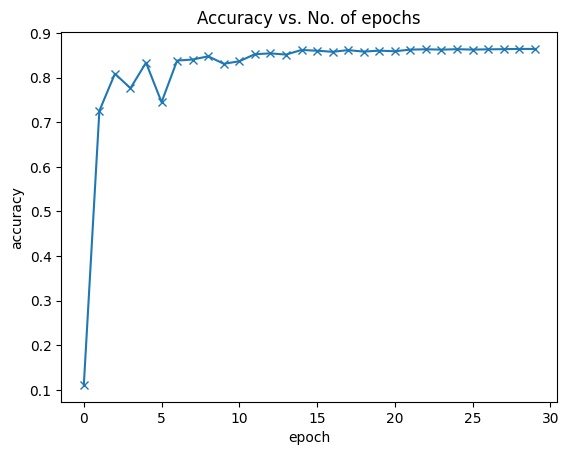

In [57]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

## **Prediction on Samples**

In [58]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: Ankle boot , Predicted: Ankle boot


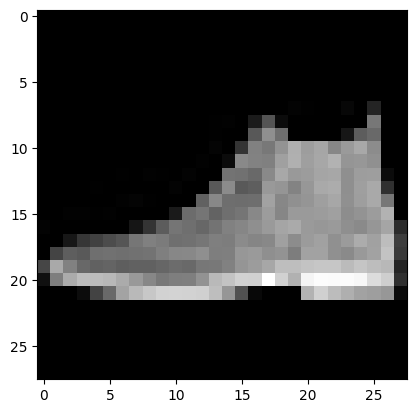

In [59]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

Label: Sandal , Predicted: Sandal


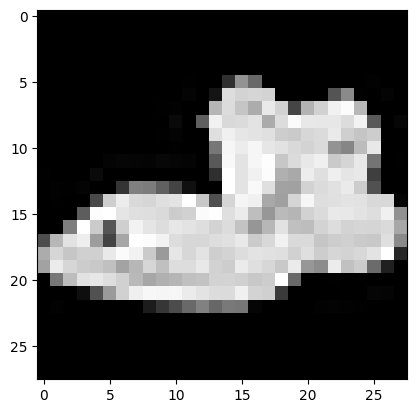

In [60]:
img, label = test_dataset[898]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])


Label: Trouser , Predicted: Trouser


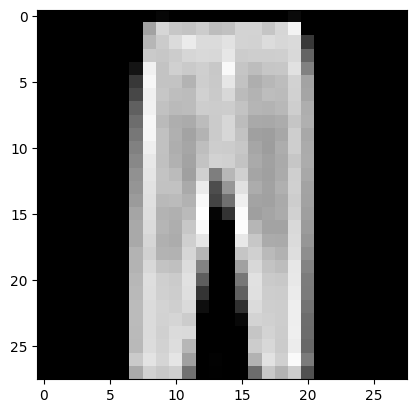

In [61]:
img, label = test_dataset[590]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

In [62]:
evaluate(model, test_loader)

{'val_loss': 0.40744635462760925, 'val_acc': 0.8566129207611084}